<a href="https://colab.research.google.com/github/Kev007s/Big-data-analisis-semester-5/blob/main/Analisis_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import re

from prophet import Prophet

In [ ]:
data1 = pd.read_excel('/content/sample_data/PENJUALAN JAN-MARET(test).xlsx')
data2 = pd.read_excel('/content/sample_data/PENJUALAN APRIL - JUNI 2024(test).xlsx')

data = pd.concat([data1, data2], ignore_index=True)
data = data[~data['Invoice Date'].astype(str).str.contains('Subtotal', na=False)]
data = data[pd.to_datetime(data['Invoice Date'], errors='coerce').notna()]
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'])
data = data.ffill()

data.to_csv('/content/Download/updated_file.csv', index=False)  # Save to /content/Download

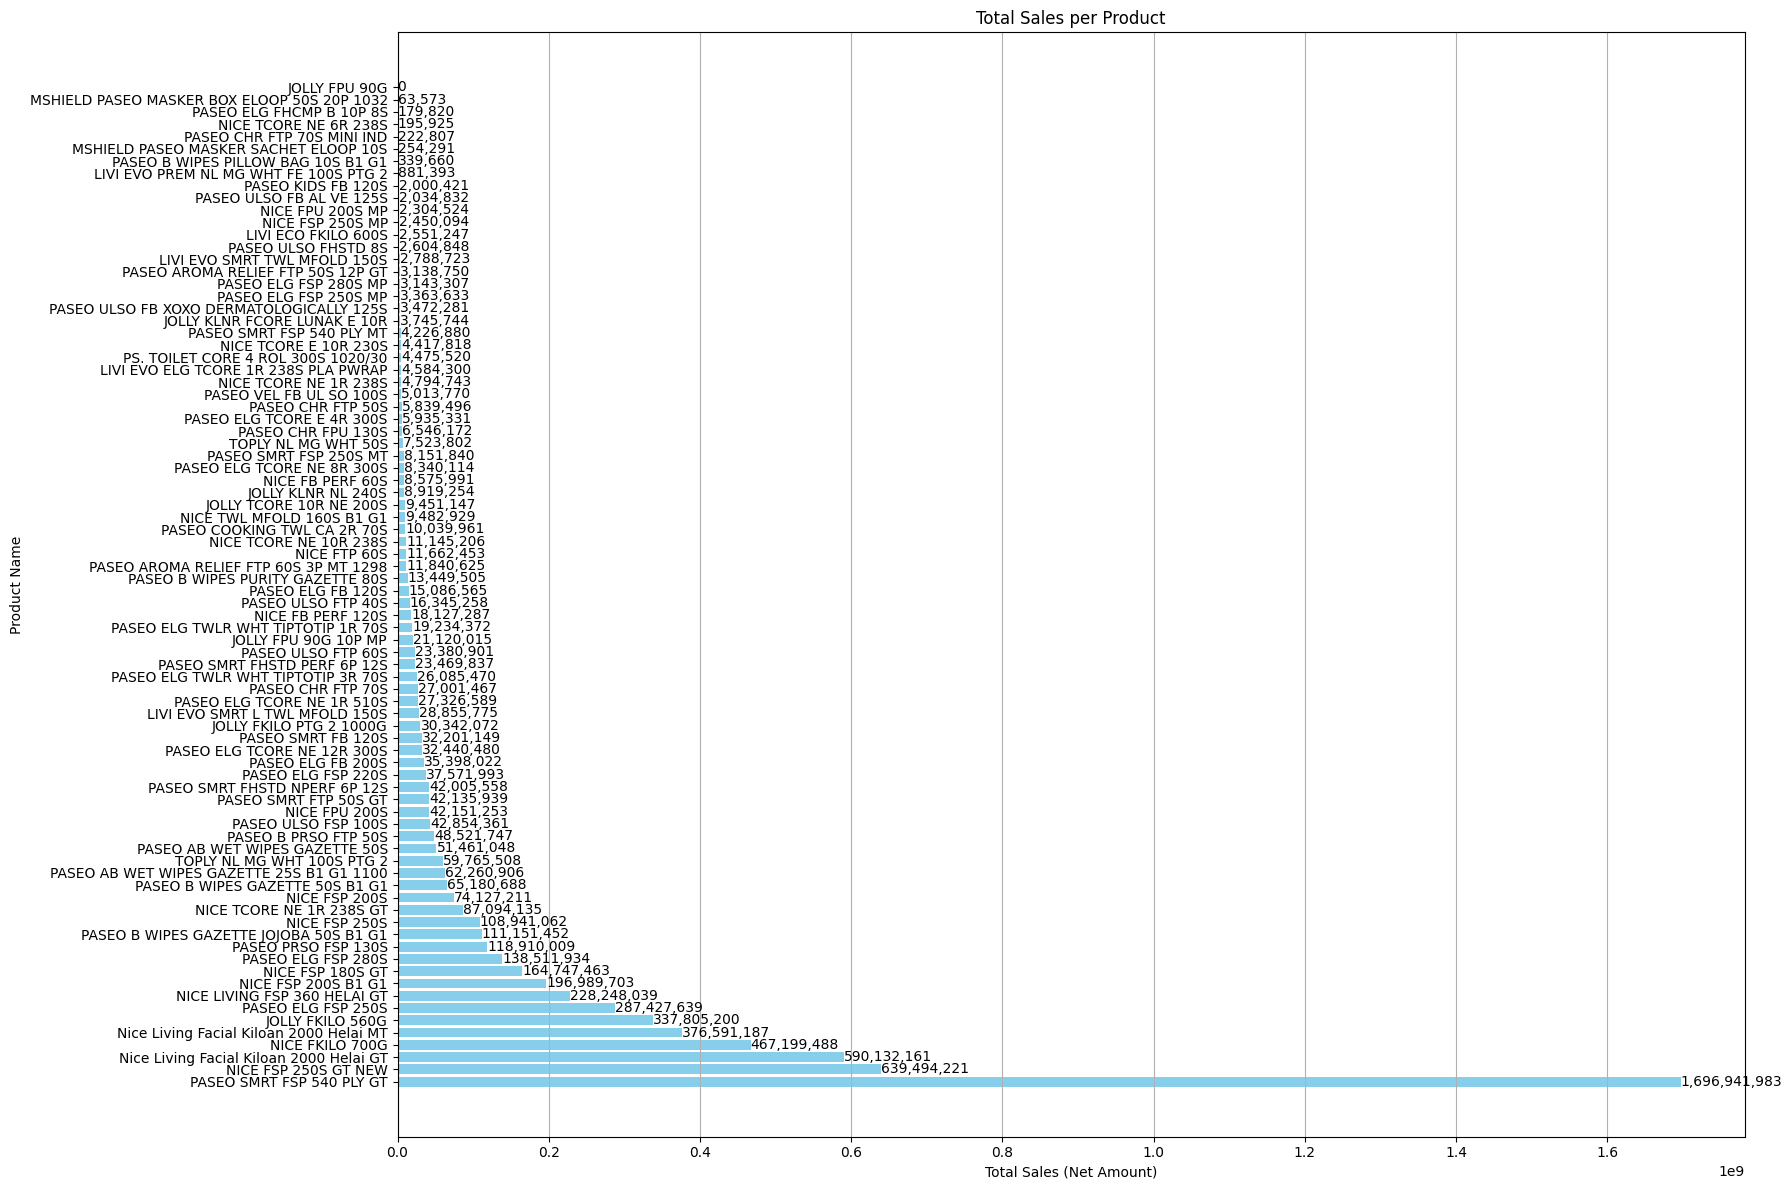

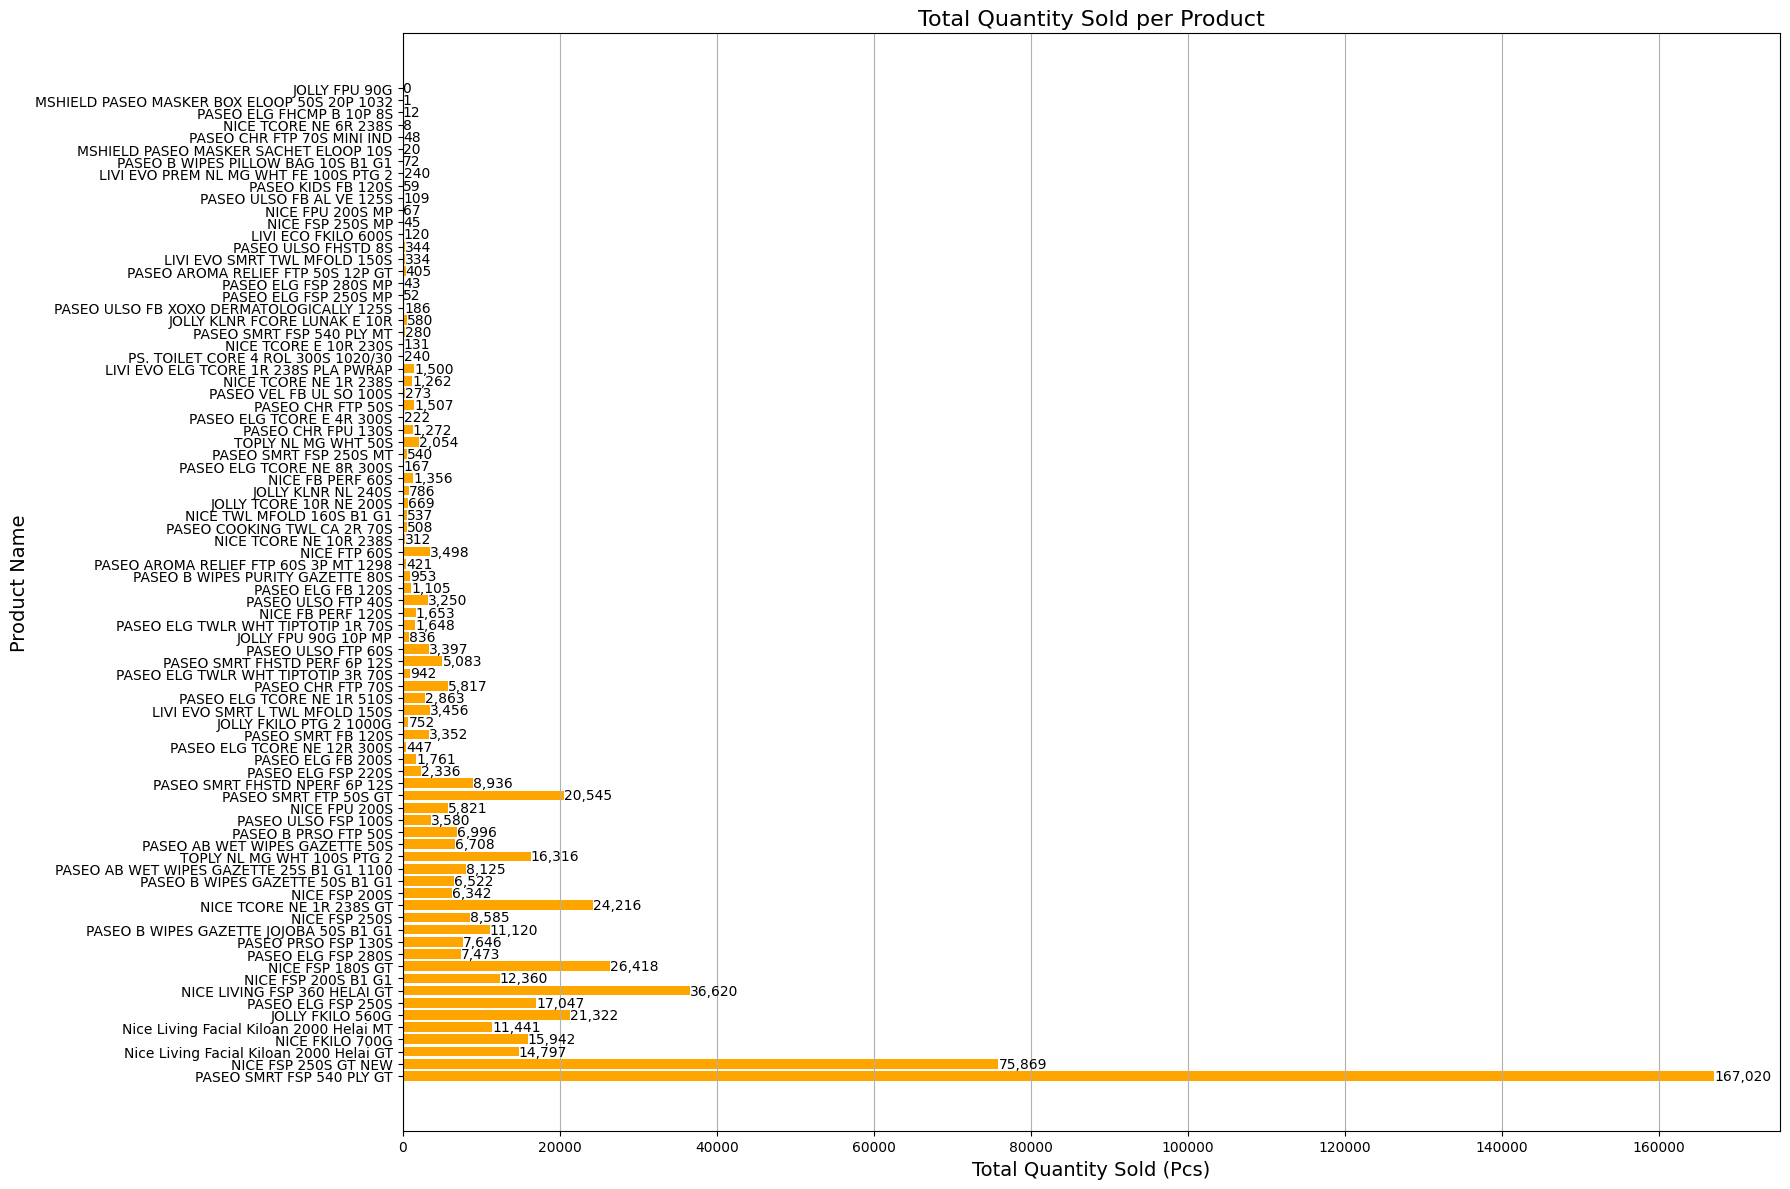

In [ ]:
# Group by 'Product Code' and 'Product Name' to calculate total sales, transaction counts, and total quantity sold
product_summary = data.groupby(['Product Code', 'Product Name']).agg(
    total_sales=('Net Amount', 'sum'),
    transaction_count=('Invoice Date', 'count'),
    total_quantity=('Qty (Pcs)', 'sum')  # Total quantity sold using the correct column name
).reset_index()

# Sort the summary by total sales in descending order for better visualization
product_summary = product_summary.sort_values(by='total_sales', ascending=False)

# Create a figure for Total Sales
plt.figure(figsize=(18, 12))
bars = plt.barh(product_summary['Product Name'], product_summary['total_sales'], color='skyblue')
plt.title('Total Sales per Product')
plt.xlabel('Total Sales (Net Amount)')
plt.ylabel('Product Name')
plt.xticks(fontsize=10)  # Set x-tick font size
plt.yticks(fontsize=10)  # Set y-tick font size
plt.grid(axis='x')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}',
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

# Create a figure for Total Quantity Sold
plt.figure(figsize=(18, 12))
bars = plt.barh(product_summary['Product Name'], product_summary['total_quantity'], color='orange')
plt.title('Total Quantity Sold per Product', fontsize=16)
plt.xlabel('Total Quantity Sold (Pcs)', fontsize=14)
plt.ylabel('Product Name', fontsize=14)
plt.xticks(fontsize=10)  # Set x-tick font size
plt.yticks(fontsize=10)  # Set y-tick font size
plt.grid(axis='x')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}',
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

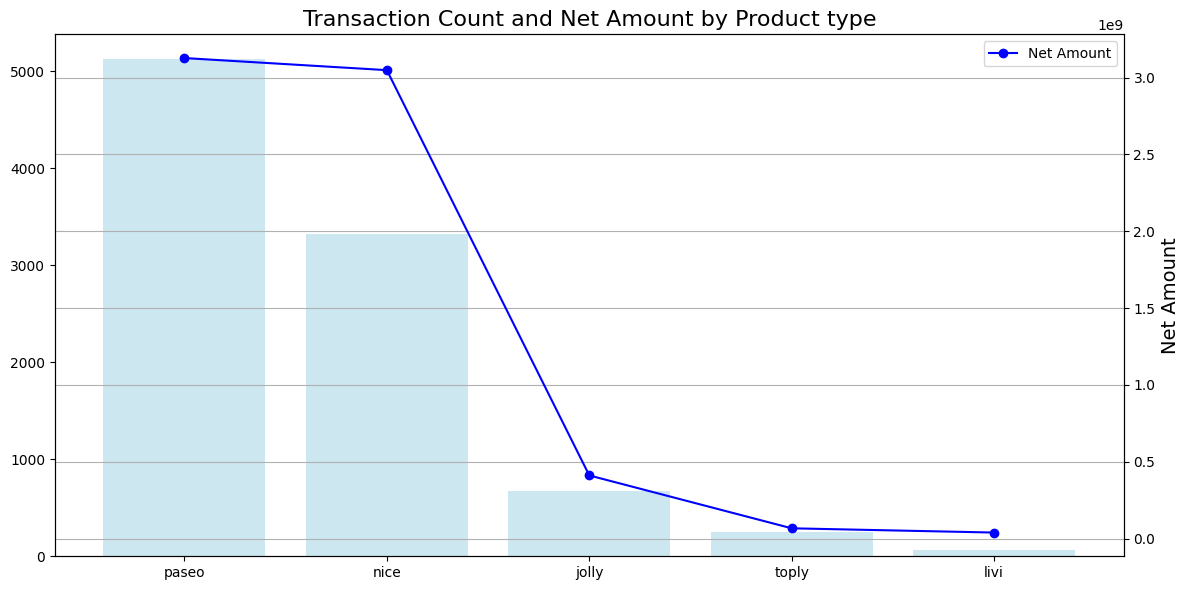

In [ ]:
# Function to clean the Product Code
def clean_product_code(code):
    # Use regex to remove numbers and special characters, keeping only alphabetic characters
    return ''.join(re.findall(r'[a-zA-Z]+', code)).lower()

# Apply the cleaning function to the 'Product Code' column
data['Cleaned Product Code'] = data['Product Code'].apply(clean_product_code)

# Group by the cleaned product code and aggregate the required columns
summary = data.groupby('Cleaned Product Code').agg({
    'Invoice Date': 'count',  # Count of transactions
    'Net Amount': 'sum'       # Total net amount
}).rename(columns={'Invoice Date': 'Transaction Count'}).reset_index()

# Sort the summary by 'Net Amount' in descending order
summary = summary.sort_values(by='Net Amount', ascending=False)

# Create a figure for visualizing the transaction count and net amount
plt.figure(figsize=(12, 6))
plt.bar(summary['Cleaned Product Code'], summary['Transaction Count'], alpha=0.6, label='Transaction Count', color='lightblue')
ax2 = plt.gca().twinx()
ax2.plot(summary['Cleaned Product Code'], summary['Net Amount'], marker='o', label='Net Amount', color='blue')

# Adding titles and labels
plt.title('Transaction Count and Net Amount by Product type', fontsize=16)
plt.xlabel('Product Code', fontsize=14)
plt.ylabel('Transaction Count', fontsize=14)
ax2.set_ylabel('Net Amount', fontsize=14)
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

                           Customer Name  purchase_count  \
0                                 A MART              63   
1                    ABDUL KADIR MANSYUR               1   
2                   ABDUL RAHMAN / NAKES               5   
3    ABDUL RASYID MAJID (KIOS SUMBER MAS               8   
4                                   ABEL              10   
..                                   ...             ...   
239                              UMAR AM               5   
240                         USP UNIVENUS              50   
241                       VALENTINE CAFE               5   
242                         WELCOME MART             235   
243         WILI PRATAMA W. SURYA MAKMUR              15   

          Frequency Segment  
0    More than 10 Purchases  
1                1 Purchase  
2             4-5 Purchases  
3            6-10 Purchases  
4            6-10 Purchases  
..                      ...  
239           4-5 Purchases  
240  More than 10 Purchases  
241      

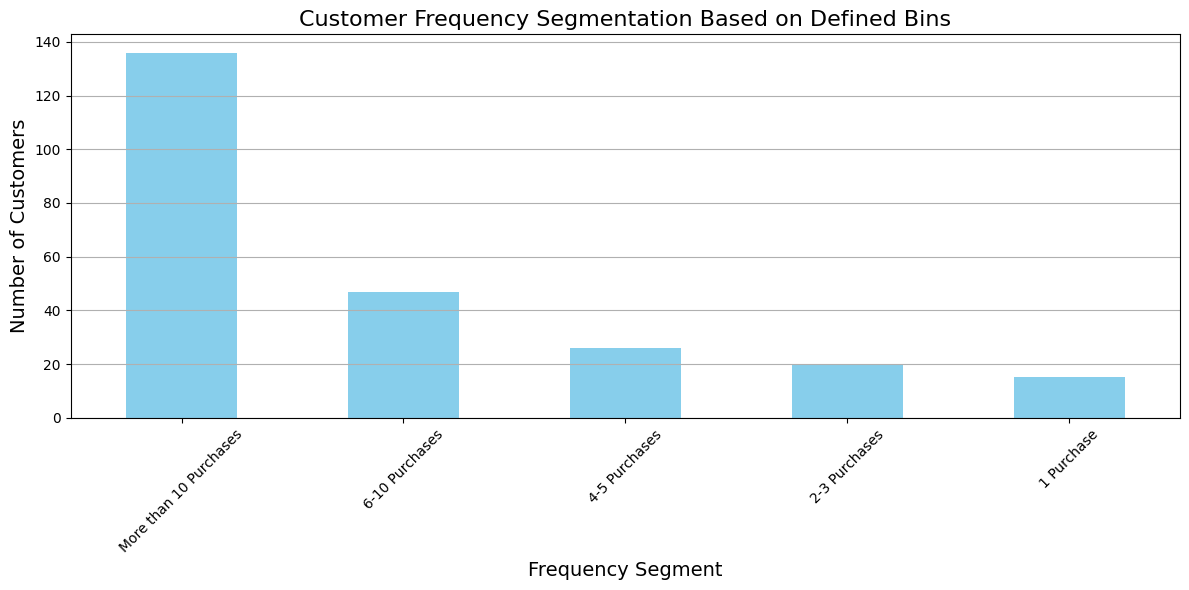

In [ ]:
# Group by 'Customer Name' to calculate purchase frequency
customer_summary = data.groupby('Customer Name').agg(
    purchase_count=('Invoice Date', 'count'),
    total_spent=('Net Amount', 'sum')
).reset_index()

# Define bins for frequency segmentation
bins = [0, 1, 3, 5, 10, float('inf')]
labels = ['1 Purchase', '2-3 Purchases', '4-5 Purchases', '6-10 Purchases', 'More than 10 Purchases']

# Assign frequency segments based on purchase count
customer_summary['Frequency Segment'] = pd.cut(customer_summary['purchase_count'], bins=bins, labels=labels)

# Display the segmented summary
print(customer_summary[['Customer Name', 'purchase_count', 'Frequency Segment']])

# Visualize the segments
plt.figure(figsize=(12, 6))

# Count of customers in each frequency segment
frequency_counts = customer_summary['Frequency Segment'].value_counts()
frequency_counts.plot(kind='bar', color='skyblue')
plt.title('Customer Frequency Segmentation Based on Defined Bins', fontsize=16)
plt.xlabel('Frequency Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


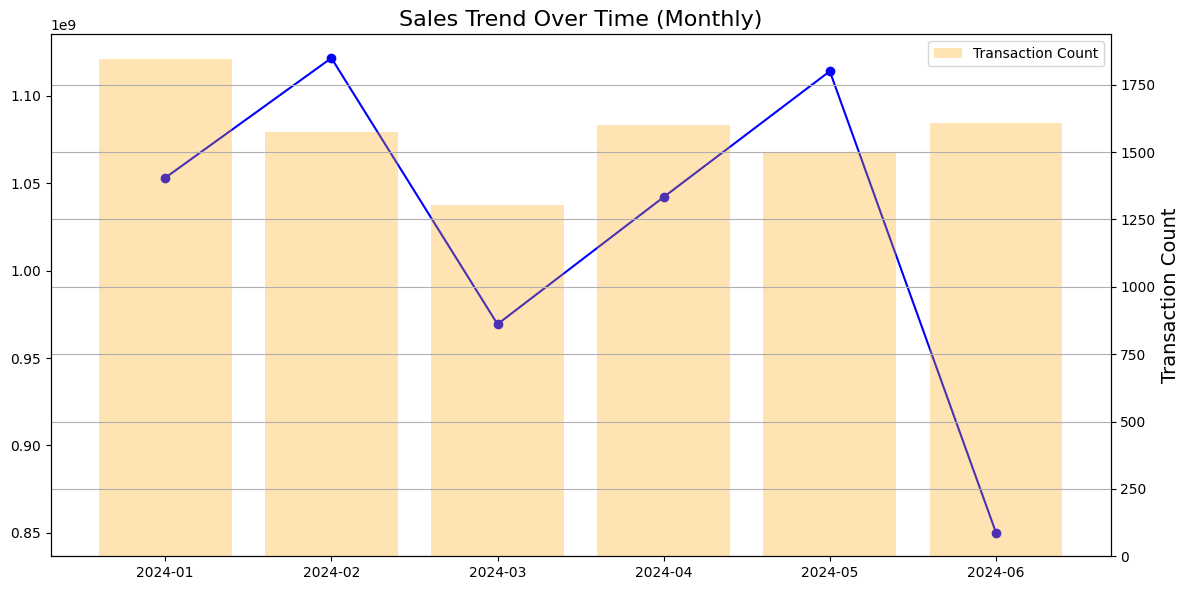

In [ ]:
# Convert 'Invoice Date' to datetime format
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'], errors='coerce')

# Create a new column for the month
data['Month'] = data['Invoice Date'].dt.to_period('M')

# Group by Month and aggregate total sales and count of transactions
sales_trend = data.groupby('Month').agg({
    'Gross Amount': 'sum',  # Total gross amount
    'Invoice Date': 'count'  # Count of transactions
}).rename(columns={'Invoice Date': 'Transaction Count'}).reset_index()

# Convert 'Month' back to a string for plotting
sales_trend['Month'] = sales_trend['Month'].dt.strftime('%Y-%m')

# Create a figure for visualizing the sales trend
plt.figure(figsize=(12, 6))

# Plotting Total Gross Amount
plt.plot(sales_trend['Month'], sales_trend['Gross Amount'], marker='o', label='Total Gross Amount', color='blue')

# Create a second y-axis for Transaction Count
ax2 = plt.gca().twinx()
ax2.bar(sales_trend['Month'], sales_trend['Transaction Count'], alpha=0.3, label='Transaction Count', color='orange')

# Adding titles and labels
plt.title('Sales Trend Over Time (Monthly)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Gross Amount', fontsize=14)
ax2.set_ylabel('Transaction Count', fontsize=14)

# Formatting the x-axis
plt.xticks(rotation=45)
plt.grid()

# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


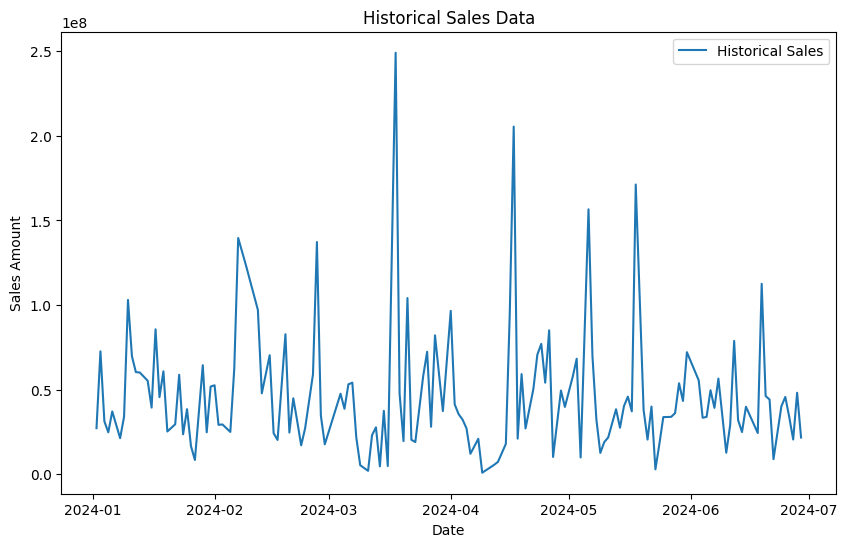

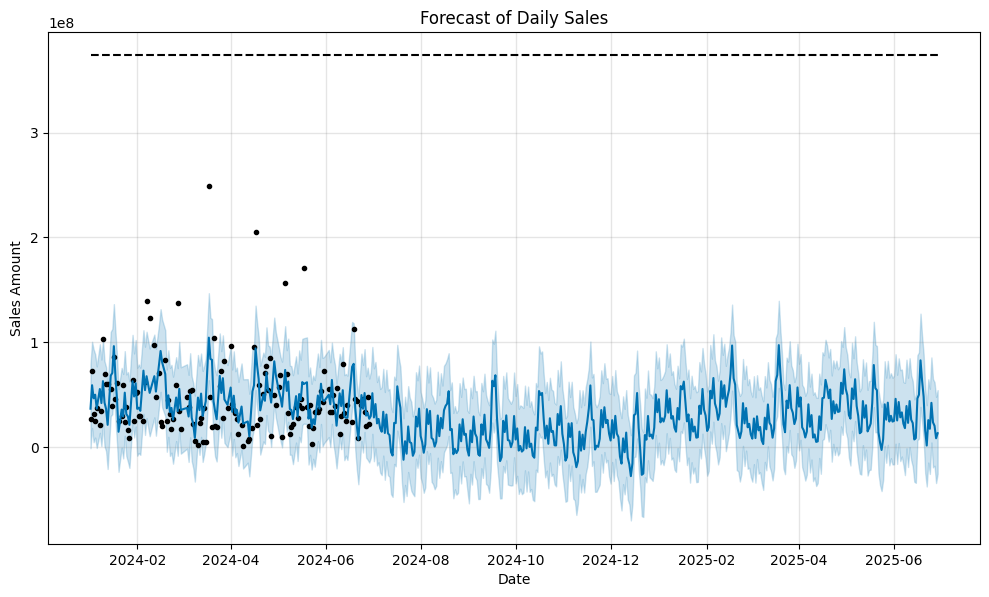

            ds          yhat    yhat_lower    yhat_upper
504 2025-06-25  4.215586e+07  4.282700e+06  8.549866e+07
505 2025-06-26  2.354333e+07 -1.944403e+07  6.492080e+07
506 2025-06-27  2.022458e+07 -1.788999e+07  6.184462e+07
507 2025-06-28  8.333223e+06 -3.442562e+07  4.790070e+07
508 2025-06-29  1.315355e+07 -2.560884e+07  5.431256e+07


In [ ]:
# Group by date and aggregate total transaction counts and sales amount
data_daily = data.groupby('Invoice Date').agg({
    'Net Amount': 'sum'  # Total sales amount
}).reset_index()

# Rename the columns for Prophet
data_daily.columns = ['ds', 'y']  # 'ds' for date, 'y' for sales amount

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(data_daily['ds'], data_daily['y'], label='Historical Sales')
plt.title('Historical Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.show()

# Set a cap for logistic growth (optional, adjust the value based on your expectations)
# Ensure that the cap is reasonable. Adjust this value based on your data
data_daily['cap'] = data_daily['y'].max() * 1.5  # Set the cap 50% higher than max historical value (instead of 20%)

# Initialize and fit the Prophet model with logistic growth and yearly seasonality
model = Prophet(
    growth='logistic',        # Use logistic growth
    yearly_seasonality=True,  # Enable yearly seasonality
    daily_seasonality=False   # Disable daily seasonality
)

# Add additional seasonality (e.g., monthly seasonality)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the model
model.fit(data_daily)

# Create a DataFrame for future dates (e.g., 12 months ahead)
future = model.make_future_dataframe(periods=365, freq='D')  # Forecast for daily values, 365 days ahead
future['cap'] = data_daily['cap'].max()  # Add cap column to future DataFrame

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.show()

# Print the forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())